In [1]:
import cartopy.crs as ccrs # type: ignore
import matplotlib.pyplot as plt # type: ignore
import numpy as np # type: ignore
import pandas as pd # type: ignore
import xarray as xa # type: ignore

proj_nps = ccrs.NorthPolarStereo()
proj_pc = ccrs.PlateCarree()

In [2]:
ifile = '/Data/sat/downloads/CS2/LARM/uit_cryosat2_L2_alongtrack_2020_01.txt'
df = pd.read_csv(ifile)
col_mapper = {i:i.strip().replace('#', 'no') for i in df.columns}
df.rename(mapper=col_mapper, axis=1, inplace=True)
print(df.columns)

Index(['Operating_Mode', 'Orbit_no', 'Segment_no', 'Datenumber', 'Latitude',
       'Longitude', 'Radar_Freeboard', 'Surface_Height_WGS84',
       'Sea_Surface_Height_Interp_WGS84', 'SSH_Uncertainty',
       'Mean_Sea_Surface', 'SLA', 'Sea_Ice_Class', 'Lead_Class',
       'Sea_Ice_Roughness', 'Sea_Ice_Concentration'],
      dtype='object')


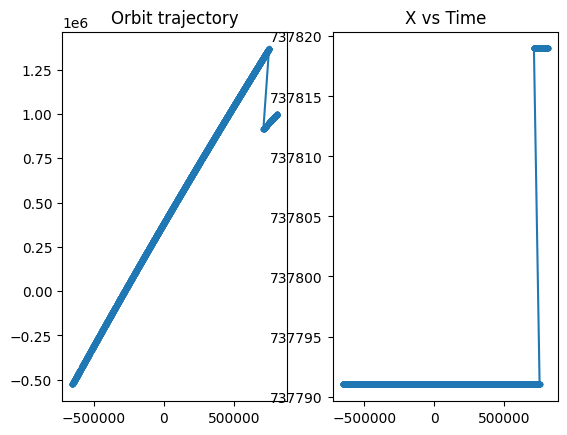

In [3]:
# The field Orbit_# seems to contain incorrect values
# E.g., if we subselect by orbit number an plot, we will see points belonging to different orbits
subdf = df[(df['Orbit_no'] == 1)]
x, y, _ = proj_nps.transform_points(proj_pc, subdf['Longitude'], subdf['Latitude']).T

fig, axs = plt.subplots(1, 2)
axs[0].plot(x, y, '.-')
axs[0].set_title('Orbit trajectory')
axs[1].plot(x, subdf['Datenumber'], '.-')
axs[1].set_title('X vs Time')
plt.show()

In [4]:
# Creating new orbit#
# find difference between observations in seconds
date_diff_sec = df['Datenumber'].diff().to_numpy()*60*60*24
# find indices of obs. where time difference is more than 1000 sec (one orbit is ~5000 sec)
orbit_starts_ends = np.hstack([0, np.nonzero(date_diff_sec > 1000)[0], date_diff_sec.size + 1])
# loop over indices and creacte correct orbit_no
orbit_no = np.zeros(date_diff_sec.size)
for i, (orbit_start, orbit_end) in enumerate(zip(orbit_starts_ends[:-1], orbit_starts_ends[1:])):
    orbit_no[orbit_start:orbit_end] = i
df['orbit_no'] = orbit_no

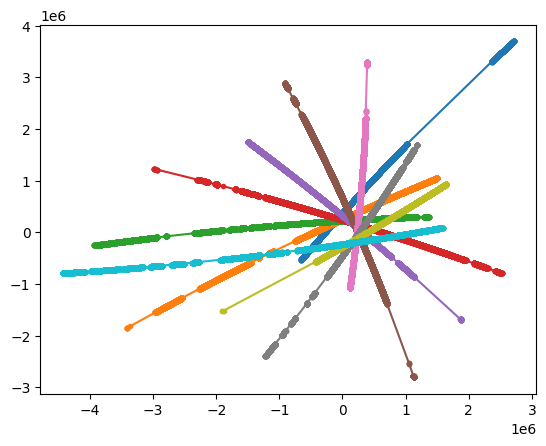

In [5]:
# Plot several orbits for testing
for i in range(10):
    subdf = df[(df['orbit_no'] == i)]
    x, y, _ = proj_nps.transform_points(proj_pc, subdf['Longitude'], subdf['Latitude']).T
    plt.plot(x, y, '.-')
plt.show()


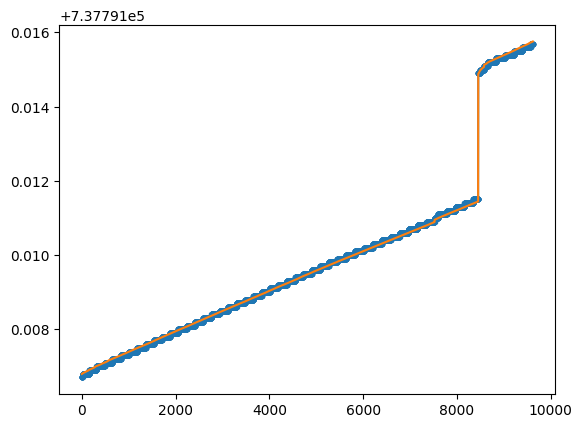

In [6]:
def compute_accurate_time(df, i):
    """
    Datenumber is given with limited precision but we need accurate time for correct window filtering.
    Accurate time can be approximated as distance from the first measurement in the orbit divided by speed.
    Absolute time is not so important for further analysis, but time difference between the measurements is crucial.

    Inputs:
    df : DataFrame with all L2 measuremenst
    i : orbit number

    Returns:
    datenumber_accurate : precise datetime as floating point ordinal datetime
    """
    # select one orbit
    subdf = df[(df['orbit_no'] == i)]

    # compute distance from orbit start
    x, y, _ = proj_nps.transform_points(proj_pc, subdf['Longitude'], subdf['Latitude']).T
    dist = np.hypot(x - x[0], y - y[0])

    # compute scale = 1/speed and offset by fitting to discrete (imprecise) date
    dist_scale, dist_offset = np.polyfit(dist, subdf['Datenumber'], 1)
    # compute precise time
    datenumber_accurate = dist_offset + dist * dist_scale
    return datenumber_accurate

i = 0
datenumber_accurate = compute_accurate_time(df, i)

# plotfor testing
plt.plot(df[(df['orbit_no'] == i)]['Datenumber'].to_numpy(), '.-')
plt.plot(datenumber_accurate, '-')
plt.show()


In [7]:
def convert_time_index(datenumber_accurate):
    """ Convert the floating point Datenumber to pandas.DateTimeIndex"""
    ordinal0 = int(datenumber_accurate[0])
    date0 = pd.Timestamp.fromordinal(ordinal0)
    deltas = datenumber_accurate - ordinal0
    date_time_ndex = date0 + pd.to_timedelta(deltas * 60 * 60 * 24, 's')
    return date_time_ndex

In [8]:
# create DateTimeIndex for the entire DataFrame
dti = pd.DatetimeIndex([])
for i in np.unique(orbit_no):
    datenumber_accurate = compute_accurate_time(df, i)
    dti = dti.append(convert_time_index(datenumber_accurate))

df.index = dti

In [9]:
df

,Operating_Mode,Orbit_no,Segment_no,Datenumber,Latitude,Longitude,Radar_Freeboard,Surface_Height_WGS84,Sea_Surface_Height_Interp_WGS84,SSH_Uncertainty,Mean_Sea_Surface,SLA,Sea_Ice_Class,Lead_Class,Sea_Ice_Roughness,Sea_Ice_Concentration,orbit_no
2021-01-01 00:09:47.139643729,1,1,1,737791.0067,82.500548,-51.037944,0.154022,19.165928,19.011906,0.003196,18.988321,NaN,1,0,0.184628,0.9645,0.0
2021-01-01 00:09:47.183216214,1,1,1,737791.0067,82.503151,-51.043729,0.218059,19.234370,19.016311,0.003126,18.992549,NaN,1,0,0.099511,0.9645,0.0
2021-01-01 00:09:47.226778641,1,1,1,737791.0067,82.505752,-51.049518,0.266091,19.287661,19.021569,0.003057,18.997631,NaN,1,0,0.042989,0.9645,0.0
2021-01-01 00:09:47.270351127,1,1,1,737791.0067,82.508354,-51.055310,0.246202,19.272923,19.026721,0.002989,19.002605,NaN,1,0,0.050188,0.9645,0.0
2021-01-01 00:09:47.313913554,1,1,1,737791.0067,82.510956,-51.061107,0.225887,19.258638,19.032751,0.002921,19.008458,NaN,1,0,0.053245,0.9645,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-31 22:54:26.270481795,0,1317,2168,737821.9544,53.583599,143.086669,NaN,17.909693,17.910527,0.016150,17.796039,0.113653,0,1,NaN,0.8938,445.0
2021-01-31 22:54:26.319173947,0,1317,2168,737821.9544,53.580873,143.086208,NaN,17.919528,17.911256,0.016047,17.792457,0.127071,0,1,NaN,0.8938,445.0
2021-01-31 22:54:26.367876157,0,1317,2168,737821.9544,53.578147,143.085746,NaN,17.897896,17.907624,0.015964,17.788793,0.109103,0,1,NaN,0.8938,445.0
2021-01-31 22:54:26.416568309,0,1317,2168,737821.9544,53.575421,143.085285,NaN,17.902243,17.903400,0.016049,17.785048,0.117194,0,1,NaN,0.8938,445.0


In [10]:
# save as netCDF for further use
xds = xa.Dataset.from_dataframe(df)
xds.to_netcdf(ifile.replace('.txt', '.nc'))